<a href="https://colab.research.google.com/github/hikaru122700/kaggle-private/blob/SMBC/079.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost
!pip install lightgbm
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.1 MB/s eta 0:00:00


In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
import math

# import pygeohash as pgh

from concurrent.futures import ThreadPoolExecutor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import matplotlib.pyplot as plt


import os
from catboost import CatBoostClassifier


In [4]:
path  = "/content/drive/My Drive/signate/SMBC Group GREEN×DATA Challenge 2024/"
# 予測モデルを訓練するためのデータセット
train_df = pd.read_csv(path+'train_all_df_078.csv', index_col=0)

# train_df.drop("GHG_Direct_Emissions_14_in_metric_tons", axis=1, inplace=True)
# 予測モデルに推論（予測)させるデータセット
test_df = pd.read_csv(path+'test_all_df_078.csv', index_col=0)

In [5]:
# すべての列を表示するように設定
pd.set_option('display.max_columns', None)
train_df.columns

Index(['TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_12_in_lbs',
       'TRI_Air_Emissions_13_in_lbs', 'PrimaryNAICS',
       'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons', 'Latitude', 'Longitude',
       'TRI_Air_Emissions_YoY_Change_11', 'TRI_Air_Emissions_YoY_Change_12',
       'TRI_Air_Emissions_YoY_Change_13', 'TRI_Air_Emissions_Growth_Rate_11',
       'TRI_Air_Emissions_Growth_Rate_12', 'TRI_Air_Emissions_Growth_Rate_13',
       'Economic_Sector', 'num_missing',
       'GHG_Direct_Emissions_14_in_metric_tons.1', 'oof_predictions'],
      dtype='object')

In [6]:
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

In [7]:

def show_plot(test_preds, target, title):
# 共通のビンエッジを定義するため、両方のデータの範囲を取得
    min_val = min(test_preds.min(), target.min())
    max_val = max(test_preds.max(), target.max())

# ビンエッジを共通化（例えば、100ビン）
    bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)

# ヒストグラムを正規化してプロット
    plt.figure(figsize=(7, 5))

# test_preds のヒストグラム
    sns.histplot(test_preds, bins=bins, stat='density', kde=True, color='blue', label='before', alpha=0.6)

# target のヒストグラム
    sns.histplot(target, bins=bins, stat='density', kde=True, color='orange', label='after', alpha=0.6)

# ログスケールを適用
    plt.xscale('log')

# ラベルとタイトルの設定
    plt.xlabel('Values (Log Scale)')
    plt.ylabel('Density')
    plt.title(title)

# 凡例の表示
    plt.legend()

# グリッドの追加（オプション）
    plt.grid(True, which="both", ls="--", linewidth=0.5)

# プロットの表示
    plt.show()


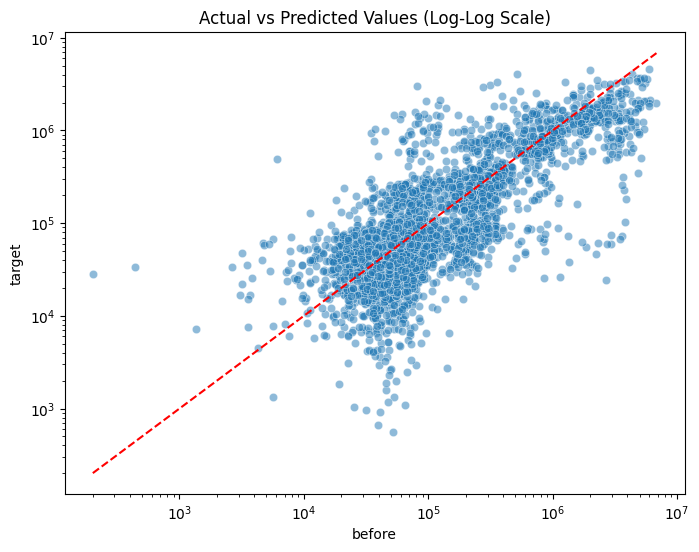

In [8]:

x=train_df["GHG_Direct_Emissions_12_in_metric_tons"]
y=train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]
# 実測値と予測値を対数スケールでプロット
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('before')
plt.ylabel('target')
plt.title('Actual vs Predicted Values (Log-Log Scale)')
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')  # 45度線
plt.show()

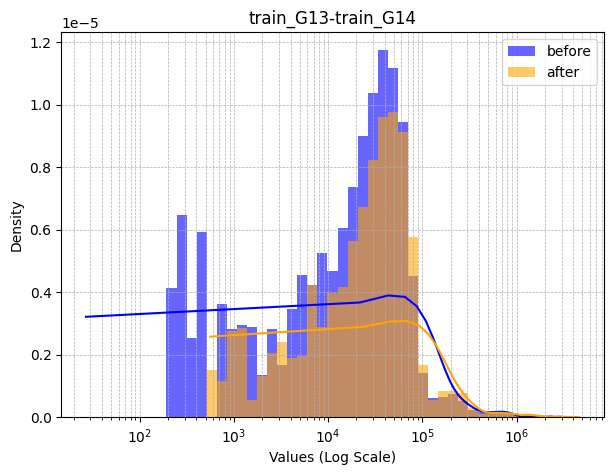

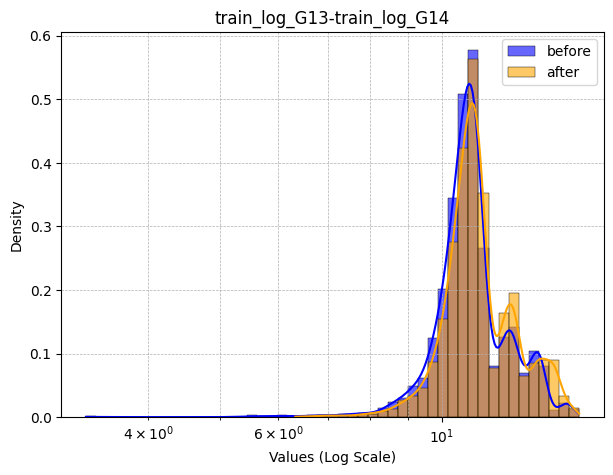

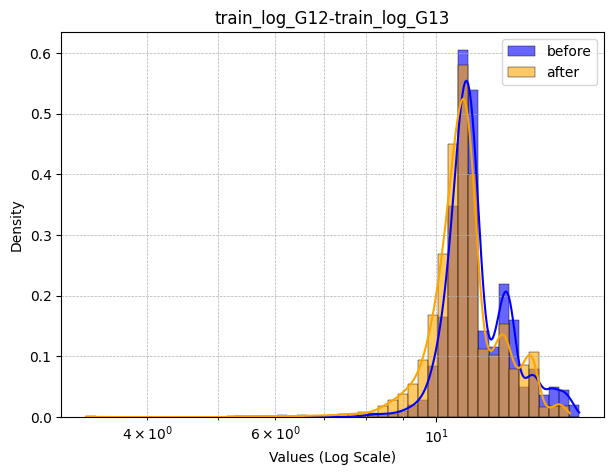

In [9]:

show_plot(train_df["GHG_Direct_Emissions_13_in_metric_tons"],
          train_df["GHG_Direct_Emissions_14_in_metric_tons.1"],
          "train_G13-train_G14")
show_plot(np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]),
          np.log(train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]),
          "train_log_G13-train_log_G14")
show_plot(np.log(train_df["GHG_Direct_Emissions_12_in_metric_tons"]),
          np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]),
          "train_log_G12-train_log_G13")


In [10]:
train_all_df = pd.concat([train_df, test_df], axis=0)
train_all_df["GHG_Direct_Emissions_14_in_metric_tons.1"][len(train_df):] = test_df["test_preds"]
print(train_all_df.columns)
train_all_df.drop('test_preds', axis=1, inplace=True)

test_df.rename(columns={'test_preds': 'oof_predictions'}, inplace=True)

Index(['TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_12_in_lbs',
       'TRI_Air_Emissions_13_in_lbs', 'PrimaryNAICS',
       'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons', 'Latitude', 'Longitude',
       'TRI_Air_Emissions_YoY_Change_11', 'TRI_Air_Emissions_YoY_Change_12',
       'TRI_Air_Emissions_YoY_Change_13', 'TRI_Air_Emissions_Growth_Rate_11',
       'TRI_Air_Emissions_Growth_Rate_12', 'TRI_Air_Emissions_Growth_Rate_13',
       'Economic_Sector', 'num_missing',
       'GHG_Direct_Emissions_14_in_metric_tons.1', 'oof_predictions',
       'test_preds'],
      dtype='object')


In [11]:
train_all_df

,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,GHG_Direct_Emissions_14_in_metric_tons.1,oof_predictions
0,NaN,NaN,NaN,221,9.803362e+04,49591.258795,5.839936e+04,55458.787269,39.366690,-97.799430,NaN,NaN,NaN,NaN,NaN,NaN,14,1,9.897429e+03,54986.677781
1,NaN,NaN,NaN,240,4.652013e+04,39261.527827,4.922304e+04,28222.699429,41.037617,-85.208453,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1.026454e+05,38312.576603
2,NaN,NaN,NaN,80,2.972544e+06,908113.540089,3.375397e+05,329206.449634,33.416151,-81.896431,NaN,NaN,NaN,NaN,NaN,NaN,8,1,1.835038e+06,586225.629912
3,NaN,NaN,NaN,240,1.197903e+04,37278.738945,5.316759e+04,60125.001392,38.622463,-78.586795,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1.491725e+04,43117.455179
4,176916.939324,85503.349289,103787.620581,95,3.251417e+06,432916.880509,2.980333e+05,601347.581361,41.681417,-83.457722,97947.895703,-91413.590035,18284.271292,1.240333,-0.516703,0.213843,8,0,2.460800e+05,495272.288025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,240,1.105231e+05,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.230794e+05,NaN
2504,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.003121e+05,NaN
2505,23592.402994,25069.498286,24560.172725,132,1.665202e+05,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.349400e+05,NaN
2506,140816.449347,93118.705227,130326.946431,98,7.177380e+04,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.626193e+05,NaN


In [13]:
train_all_df

,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,GHG_Direct_Emissions_14_in_metric_tons.1,oof_predictions
0,NaN,NaN,NaN,221,9.803362e+04,49591.258795,5.839936e+04,55458.787269,39.366690,-97.799430,NaN,NaN,NaN,NaN,NaN,NaN,14,1,9.897429e+03,54986.677781
1,NaN,NaN,NaN,240,4.652013e+04,39261.527827,4.922304e+04,28222.699429,41.037617,-85.208453,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1.026454e+05,38312.576603
2,NaN,NaN,NaN,80,2.972544e+06,908113.540089,3.375397e+05,329206.449634,33.416151,-81.896431,NaN,NaN,NaN,NaN,NaN,NaN,8,1,1.835038e+06,586225.629912
3,NaN,NaN,NaN,240,1.197903e+04,37278.738945,5.316759e+04,60125.001392,38.622463,-78.586795,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1.491725e+04,43117.455179
4,176916.939324,85503.349289,103787.620581,95,3.251417e+06,432916.880509,2.980333e+05,601347.581361,41.681417,-83.457722,97947.895703,-91413.590035,18284.271292,1.240333,-0.516703,0.213843,8,0,2.460800e+05,495272.288025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,240,1.105231e+05,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.230794e+05,NaN
2504,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.003121e+05,NaN
2505,23592.402994,25069.498286,24560.172725,132,1.665202e+05,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.349400e+05,NaN
2506,140816.449347,93118.705227,130326.946431,98,7.177380e+04,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.626193e+05,NaN


In [14]:
len(train_df), len(train_all_df), len(test_df)

(4379, 7163, 2508)

In [15]:
# 1. RMSLEの計算（ベクトル化）
# 'test_preds' と 'oof_predictions' を明示的に指定
diff = np.log1p(train_all_df['GHG_Direct_Emissions_14_in_metric_tons.1']) - np.log1p(train_all_df['oof_predictions'])
train_all_df['diff'] = diff
train_df = train_all_df[:4655]
test_df = train_all_df[4655:]

In [16]:
train_all_df

,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,GHG_Direct_Emissions_14_in_metric_tons.1,oof_predictions,diff
0,NaN,NaN,NaN,221,9.803362e+04,49591.258795,5.839936e+04,55458.787269,39.366690,-97.799430,NaN,NaN,NaN,NaN,NaN,NaN,14,1,9.897429e+03,54986.677781,-1.714733
1,NaN,NaN,NaN,240,4.652013e+04,39261.527827,4.922304e+04,28222.699429,41.037617,-85.208453,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1.026454e+05,38312.576603,0.985486
2,NaN,NaN,NaN,80,2.972544e+06,908113.540089,3.375397e+05,329206.449634,33.416151,-81.896431,NaN,NaN,NaN,NaN,NaN,NaN,8,1,1.835038e+06,586225.629912,1.141114
3,NaN,NaN,NaN,240,1.197903e+04,37278.738945,5.316759e+04,60125.001392,38.622463,-78.586795,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1.491725e+04,43117.455179,-1.061366
4,176916.939324,85503.349289,103787.620581,95,3.251417e+06,432916.880509,2.980333e+05,601347.581361,41.681417,-83.457722,97947.895703,-91413.590035,18284.271292,1.240333,-0.516703,0.213843,8,0,2.460800e+05,495272.288025,-0.699449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,240,1.105231e+05,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.230794e+05,NaN,NaN
2504,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.003121e+05,NaN,NaN
2505,23592.402994,25069.498286,24560.172725,132,1.665202e+05,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.349400e+05,NaN,NaN
2506,140816.449347,93118.705227,130326.946431,98,7.177380e+04,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.626193e+05,NaN,NaN


In [17]:
train_all_df["oof_predictions"].fillna(train_all_df["GHG_Direct_Emissions_14_in_metric_tons.1"], inplace=True)
train_all_df["diff"].fillna(0, inplace=True)

In [18]:
train_all_df.drop('GHG_Direct_Emissions_14_in_metric_tons.1', axis=1, inplace=True)
train_df_GHG14 = train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]
train_df.drop('GHG_Direct_Emissions_14_in_metric_tons.1', axis=1, inplace=True)

In [19]:
test_df["oof_predictions"] = test_df["GHG_Direct_Emissions_14_in_metric_tons.1"]
test_df.drop('GHG_Direct_Emissions_14_in_metric_tons.1', axis=1, inplace=True)

In [20]:
from itertools import combinations

def get_models_trained(train, test, target, num_folds, train_eval):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=13)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    train_eval_predictions = np.zeros(len(train_eval))

    # エラーの累計を保持する辞書
    sum_error = {}
    # 各組み合わせの選択回数を保持する辞書
    combination_count = {}

    # 個別モデルの名前リスト
    model_names = ["model1", "model2", "model3", "model4"]

    # 全ての組み合わせを生成（1, 2, 3, 4モデル）
    all_combinations = []
    for r in range(1, 5):
        all_combinations.extend(combinations(model_names, r))

    # 初期化
    for comb in all_combinations:
        sum_error[comb] = 0
        combination_count[comb] = 0

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"Starting Fold {fold + 1}")
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]

        # モデルと損失の初期化
        model_dict = {}
        loss_dict = {}
        valid_pred_dict = {}

        # モデル1: XGBRegressor
        params1 = {
            "n_estimators": 626,
            "max_depth": 3,
            "random_state": 13,
            "min_child_weight": 0.001190123543553736,
            "learning_rate": 0.010519736270936835,
            "subsample": 0.7304788478701394,
            "colsample_bylevel": 0.604447278915981,
            "colsample_bytree": 0.7616852136157319,
            "reg_alpha": 0.115175569924065,
            "reg_lambda": 0.07155347824929895
        }
        model1 = XGBRegressor(**params1)

        # モデル2: CatBoostRegressor
        params                       = {'iterations': 254,
                                        'depth': 5,
                                        'learning_rate': 0.08377009991199288,
                                        'l2_leaf_reg': 1,
                                        'bagging_temperature': 0.7204457890870082,
                                        'min_data_in_leaf': 4,
                                        "random_state":13,
                                         "verbose":0}
        model2                       = CatBoostRegressor(**params)

        # モデル3: XGBRegressor
        params3 ={
            "n_estimators": 897,
            "max_depth": 4,
            "min_child_weight": 1.9636282677053687,
            "learning_rate": 0.006151391207761763,
            "subsample": 0.8251910979922186,
            "colsample_bylevel": 0.6454805596196158,
            "colsample_bytree": 0.598042694363472,
            "reg_alpha": 2.1719824223479005,
            "reg_lambda": 0.009192236594241635,
        }
        model3 = XGBRegressor(**params3)

        # モデル4: CatBoostRegressor
        params4 = {
            "iterations": 940,
            "depth": 3,
            "learning_rate": 0.019908189422344794,
            "l2_leaf_reg": 1,
            "bagging_temperature": 0.5063893392618839,
            "min_data_in_leaf": 1,
            'random_state': 42
        }
        model4 = CatBoostRegressor(**params4, verbose=0)

        # 各モデルの訓練と予測
        models = {
            "model1": model1,
            "model2": model2,
            "model3": model3,
            "model4": model4
        }

        for name, model in models.items():
            model.fit(X_train, y_train)
            preds = model.predict(X_valid)
            rmsle = np.sqrt(mean_squared_error(y_valid, preds))
            print(f"Fold {fold + 1} RMSLE for {name} = {rmsle}")
            loss_dict[name] = rmsle
            valid_pred_dict[name] = preds
            sum_error[(name,)] += rmsle

        # すべての2モデルおよび3モデルの組み合わせを評価
        for r in [2, 3]:
            for comb in combinations(model_names, r):
                # 平均予測
                preds_comb = np.mean([valid_pred_dict[model] for model in comb], axis=0)
                rmsle_comb = np.sqrt(mean_squared_error(y_valid, preds_comb))
                print(f"Fold {fold + 1} RMSLE for {comb} = {rmsle_comb}")
                loss_dict[comb] = rmsle_comb
                valid_pred_dict[comb] = preds_comb
                sum_error[comb] += rmsle_comb

        # 全モデルのアンサンブル
        preds_all = np.mean([valid_pred_dict[model] for model in model_names], axis=0)
        rmsle_all = np.sqrt(mean_squared_error(y_valid, preds_all))
        print(f"Fold {fold + 1} RMSLE for all models ensemble = {rmsle_all}")
        loss_dict[tuple(model_names)] = rmsle_all
        valid_pred_dict[tuple(model_names)] = preds_all
        sum_error[tuple(model_names)] += rmsle_all

        # 最適な組み合わせを選択
        best_combination = min(loss_dict, key=loss_dict.get)
        best_rmsle = loss_dict[best_combination]
        print(f"Fold {fold + 1} best combination: {best_combination} with RMSLE = {best_rmsle}")


        # OOF予測とテスト予測の更新
        if isinstance(best_combination, tuple):
            # 複数モデルのアンサンブル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = np.mean([models[model].predict(test) for model in best_combination], axis=0)
            train_eval_preds = np.mean([models[model].predict(train_eval) for model in best_combination], axis=0)
        else:
            # 単一モデル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = models[best_combination].predict(test)
            train_eval_preds = models[best_combination].predict(train_eval)

        # 各組み合わせの選択回数をインクリメント
        # combination_count[best_combination] += 1

        test_predictions += test_preds / kf.n_splits
        train_eval_predictions += train_eval_preds/ kf.n_splits

        # メモリの解放
        del X_train, X_valid, y_train, y_valid, model1, model2, model3, model4
        gc.collect()

        print('---------------\n')

    # 最終的なOOF RMSLEの計算
    final_RMSLE = np.sqrt(mean_squared_error(target, oof_predictions))
    print(f"OOF RMSLE = {final_RMSLE}")

    # テスト予測の逆変換
    final_test_predictions = test_predictions
    final_train_predictions = train_eval_predictions

    # 各組み合わせの累積エラーと選択回数を表示
    print("Sum of RMSLE for each combination:")
    for comb, error in sum_error.items():
        print(f"{comb}: {error}")

    # print("\nNumber of times each combination was selected:")
    # for comb, count in combination_count.items():
    #     print(f"{comb}: {count}")

    return oof_predictions, final_test_predictions, final_train_predictions

In [21]:
train_df

,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,NaN,NaN,NaN,221,9.803362e+04,49591.258795,5.839936e+04,55458.787269,39.366690,-97.799430,NaN,NaN,NaN,NaN,NaN,NaN,14,1,5.498668e+04,-1.714733
1,NaN,NaN,NaN,240,4.652013e+04,39261.527827,4.922304e+04,28222.699429,41.037617,-85.208453,NaN,NaN,NaN,NaN,NaN,NaN,1,1,3.831258e+04,0.985486
2,NaN,NaN,NaN,80,2.972544e+06,908113.540089,3.375397e+05,329206.449634,33.416151,-81.896431,NaN,NaN,NaN,NaN,NaN,NaN,8,1,5.862256e+05,1.141114
3,NaN,NaN,NaN,240,1.197903e+04,37278.738945,5.316759e+04,60125.001392,38.622463,-78.586795,NaN,NaN,NaN,NaN,NaN,NaN,1,1,4.311746e+04,-1.061366
4,176916.939324,85503.349289,103787.620581,95,3.251417e+06,432916.880509,2.980333e+05,601347.581361,41.681417,-83.457722,97947.895703,-91413.590035,18284.271292,1.240333,-0.516703,0.213843,8,0,4.952723e+05,-0.699449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4650,NaN,NaN,NaN,240,2.046407e+06,275336.593090,4.630881e+06,99464.465641,37.156900,-87.380900,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1.009471e+06,0.460832
4651,NaN,NaN,NaN,21,7.034661e+04,81110.577100,5.442830e+04,29108.448339,37.220511,-82.018916,NaN,NaN,NaN,NaN,NaN,NaN,15,1,5.596748e+04,-0.204040
4652,NaN,NaN,NaN,3,2.083754e+05,57066.624445,4.858030e+04,26892.366779,42.684900,-109.780000,NaN,NaN,NaN,NaN,NaN,NaN,9,1,5.023926e+04,-0.340525
4653,NaN,NaN,NaN,244,5.637561e+05,598881.479485,1.665103e+06,543206.073134,35.484260,-97.498570,NaN,NaN,NaN,NaN,NaN,NaN,5,1,1.089507e+06,-0.107604


In [22]:
train = train_df.iloc[:, :-1].values
train_target = train_df.iloc[:, -1].values
train_all = train_all_df.iloc[:, :-1].values
train_all_target = train_all_df.iloc[:, -1].values
test = test_df.iloc[:, :-1].values

In [23]:
oof_predictions,test_preds, train_preds  = get_models_trained(train_all, test, train_all_target, 30, train)

Starting Fold 1
Fold 1 RMSLE for model1 = 0.5253136084952131
Fold 1 RMSLE for model2 = 0.5399771032982547
Fold 1 RMSLE for model3 = 0.527985624971598
Fold 1 RMSLE for model4 = 0.5297480995983017
Fold 1 RMSLE for ('model1', 'model2') = 0.5310314067721481
Fold 1 RMSLE for ('model1', 'model3') = 0.5265416763807914
Fold 1 RMSLE for ('model1', 'model4') = 0.5270713475634499
Fold 1 RMSLE for ('model2', 'model3') = 0.5323424956309395
Fold 1 RMSLE for ('model2', 'model4') = 0.5340054008675321
Fold 1 RMSLE for ('model3', 'model4') = 0.5282030490648264
Fold 1 RMSLE for ('model1', 'model2', 'model3') = 0.5295928855548402
Fold 1 RMSLE for ('model1', 'model2', 'model4') = 0.5303749832630114
Fold 1 RMSLE for ('model1', 'model3', 'model4') = 0.5271347032415559
Fold 1 RMSLE for ('model2', 'model3', 'model4') = 0.531164120495473
Fold 1 RMSLE for all models ensemble = 0.5294165881397834
Fold 1 best combination: model1 with RMSLE = 0.5253136084952131
---------------

Starting Fold 2
Fold 2 RMSLE for mode

In [24]:
test_df

,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,NaN,NaN,NaN,4,88951.390376,65803.021457,2.899329e+04,32965.487915,38.033040,-97.973170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,4.459416e+04,0.0
1,NaN,NaN,NaN,221,NaN,NaN,3.119260e+05,268668.069110,32.316030,-108.606800,NaN,NaN,NaN,NaN,NaN,NaN,14,1,2.966454e+05,0.0
2,32075.140635,26445.792090,23385.161510,130,84908.372871,6212.899604,3.473291e+04,39045.247387,41.251500,-78.742440,3800.079250,-5629.348545,-3060.630580,0.134397,-0.175505,-0.115732,8,0,4.103155e+04,0.0
3,42503.897432,43906.102080,42958.306538,82,49004.603631,52.038452,1.426237e+04,20204.924986,44.959660,-93.193410,5173.691718,1402.204648,-947.795542,0.138593,0.032990,-0.021587,8,0,3.012542e+04,0.0
4,39897.800897,40203.428231,39437.099224,181,84959.769922,15351.359676,4.000654e+04,63935.249120,32.818720,-117.125800,-5412.921803,305.627335,-766.329007,-0.119462,0.007660,-0.019061,8,0,4.757037e+04,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.230794e+05,0.0
2504,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.003121e+05,0.0
2505,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.349400e+05,0.0
2506,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.626193e+05,0.0


In [25]:
test_df["GHG_Direct_Emissions_14_in_metric_tons.1"] = np.expm1(np.log1p(test_df["oof_predictions"])+test_preds)
train_df["preds"] = np.expm1(np.log1p(train_df["oof_predictions"])+train_preds)

In [26]:
train_df

,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff,preds
0,NaN,NaN,NaN,221,9.803362e+04,49591.258795,5.839936e+04,55458.787269,39.366690,-97.799430,NaN,NaN,NaN,NaN,NaN,NaN,14,1,5.498668e+04,-1.714733,5.312985e+04
1,NaN,NaN,NaN,240,4.652013e+04,39261.527827,4.922304e+04,28222.699429,41.037617,-85.208453,NaN,NaN,NaN,NaN,NaN,NaN,1,1,3.831258e+04,0.985486,3.622895e+04
2,NaN,NaN,NaN,80,2.972544e+06,908113.540089,3.375397e+05,329206.449634,33.416151,-81.896431,NaN,NaN,NaN,NaN,NaN,NaN,8,1,5.862256e+05,1.141114,6.633360e+05
3,NaN,NaN,NaN,240,1.197903e+04,37278.738945,5.316759e+04,60125.001392,38.622463,-78.586795,NaN,NaN,NaN,NaN,NaN,NaN,1,1,4.311746e+04,-1.061366,4.085155e+04
4,176916.939324,85503.349289,103787.620581,95,3.251417e+06,432916.880509,2.980333e+05,601347.581361,41.681417,-83.457722,97947.895703,-91413.590035,18284.271292,1.240333,-0.516703,0.213843,8,0,4.952723e+05,-0.699449,4.555892e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4650,NaN,NaN,NaN,240,2.046407e+06,275336.593090,4.630881e+06,99464.465641,37.156900,-87.380900,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1.009471e+06,0.460832,1.054266e+06
4651,NaN,NaN,NaN,21,7.034661e+04,81110.577100,5.442830e+04,29108.448339,37.220511,-82.018916,NaN,NaN,NaN,NaN,NaN,NaN,15,1,5.596748e+04,-0.204040,5.541281e+04
4652,NaN,NaN,NaN,3,2.083754e+05,57066.624445,4.858030e+04,26892.366779,42.684900,-109.780000,NaN,NaN,NaN,NaN,NaN,NaN,9,1,5.023926e+04,-0.340525,4.873934e+04
4653,NaN,NaN,NaN,244,5.637561e+05,598881.479485,1.665103e+06,543206.073134,35.484260,-97.498570,NaN,NaN,NaN,NaN,NaN,NaN,5,1,1.089507e+06,-0.107604,1.089432e+06


In [27]:
oof_predictions = pd.Series(oof_predictions, name='oof_predictions')

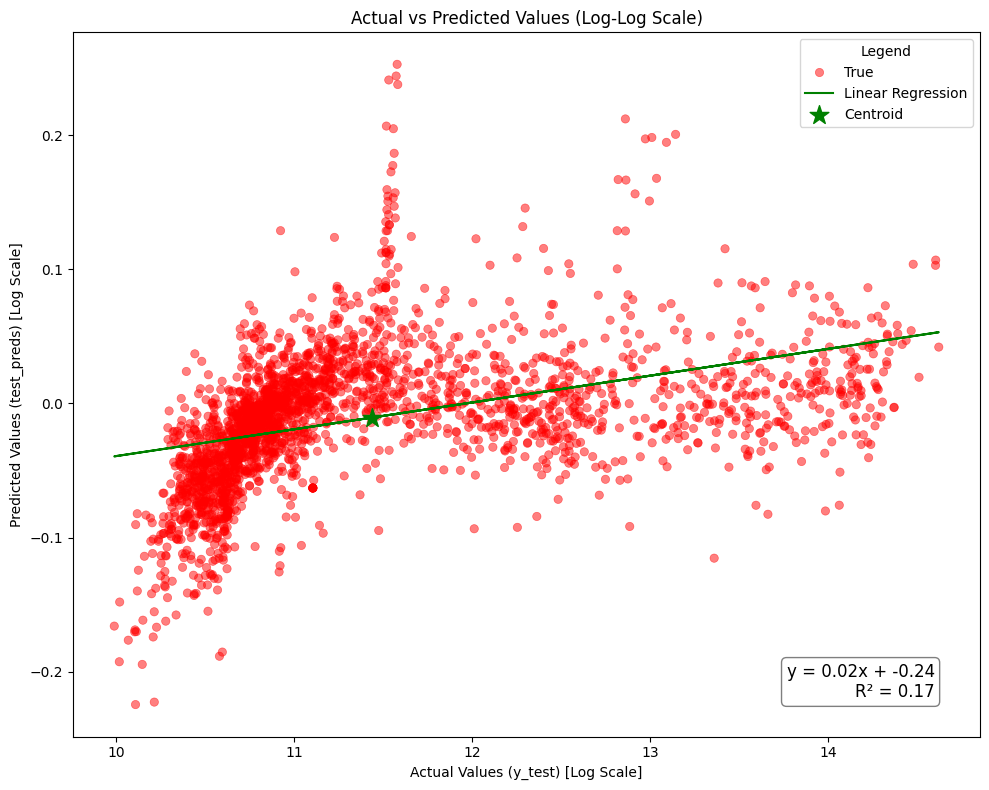

重心 (Centroid) の座標: (11.44, -0.01)


In [28]:
from scipy import stats
# 対数変換
log_target = np.log1p(test_df["oof_predictions"])
log_oof_predictions = test_preds

# 差の計算
diff = abs(log_target - log_oof_predictions)

# diffが0.7を超えるかどうかのマスク作成
diff_threshold = 0.7
mask = diff > diff_threshold

# プロットの作成
plt.figure(figsize=(10, 8))

sns.scatterplot(
    x=log_target,
    y=log_oof_predictions,
    hue=mask,
    palette={False: 'blue', True: 'red'},
    alpha=0.5,
    edgecolor=None
)

plt.xlabel('Actual Values (y_test) [Log Scale]')
plt.ylabel('Predicted Values (test_preds) [Log Scale]')
plt.title('Actual vs Predicted Values (Log-Log Scale)')

# 線形回帰の計算
slope, intercept, r_value, p_value, std_err = stats.linregress(log_target, log_oof_predictions)
regression_line = slope * log_target + intercept

# 回帰線のプロット
plt.plot(log_target, regression_line, color='green', label='Linear Regression')

# 回帰式の作成
equation = f'y = {slope:.2f}x + {intercept:.2f}'
r_squared = r_value**2
equation_r2 = f'R² = {r_squared:.2f}'

# 回帰式をグラフ内の右下に表示
plt.text(
    0.95, 0.05,  # グラフ内の相対位置 (x, y) 0-1
    f'{equation}\n{equation_r2}',
    transform=plt.gca().transAxes,
    fontsize=12,
    horizontalalignment='right',
    verticalalignment='bottom',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
)

# 重心の計算
centroid_x = np.mean(log_target)
centroid_y = np.mean(log_oof_predictions)

# 重心をプロットに追加（plt.scatterを使用）
plt.scatter(
    centroid_x,
    centroid_y,
    color='green',
    marker='*',
    s=200,  # マーカーのサイズ
    label='Centroid'
)

# 凡例の設定
plt.legend(title='Legend')

# プロットの表示
plt.tight_layout()
plt.show()

# 重心の座標を表示
print(f"重心 (Centroid) の座標: ({centroid_x:.2f}, {centroid_y:.2f})")

In [29]:
train_df_GHG14

,GHG_Direct_Emissions_14_in_metric_tons.1
0,9.897429e+03
1,1.026454e+05
2,1.835038e+06
3,1.491725e+04
4,2.460800e+05
...,...
4650,1.600409e+06
4651,4.563736e+04
4652,3.573974e+04
4653,9.783592e+05


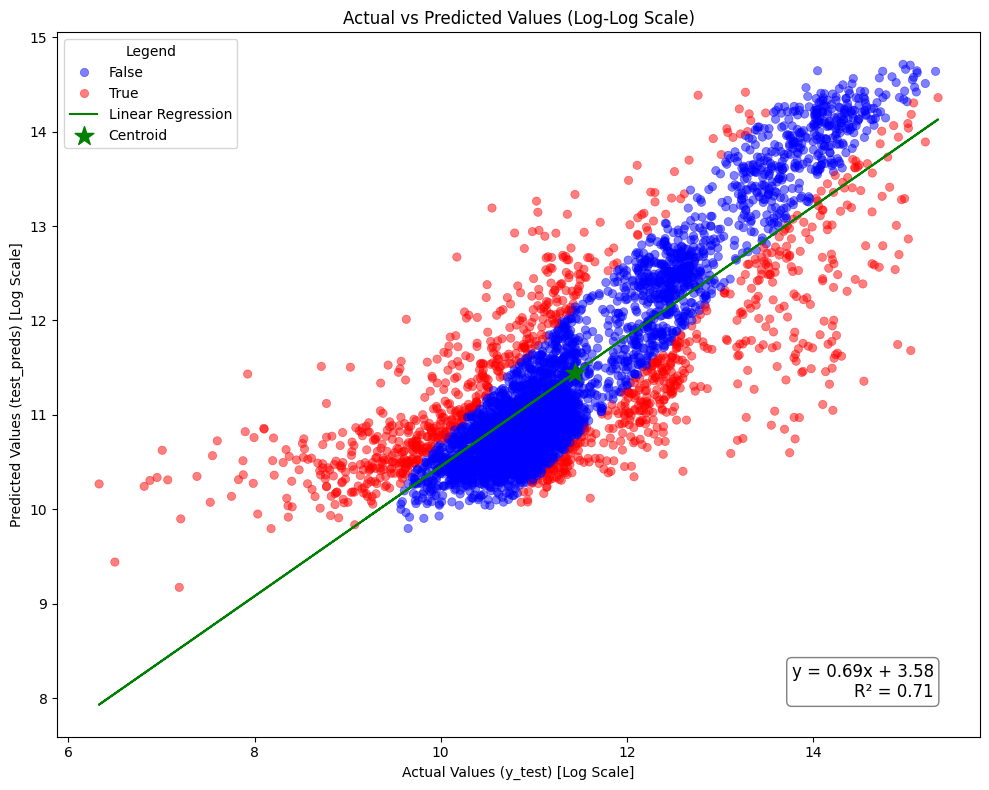

重心 (Centroid) の座標: (11.44, 11.44)


In [30]:

# 対数変換
log_target = np.log1p(train_df_GHG14)
log_oof_predictions = np.log1p(train_df["preds"])

# 差の計算
diff = abs(log_target - log_oof_predictions)

# diffが0.7を超えるかどうかのマスク作成
diff_threshold = 0.7
mask = diff > diff_threshold

# プロットの作成
plt.figure(figsize=(10, 8))

sns.scatterplot(
    x=log_target,
    y=log_oof_predictions,
    hue=mask,
    palette={False: 'blue', True: 'red'},
    alpha=0.5,
    edgecolor=None
)

plt.xlabel('Actual Values (y_test) [Log Scale]')
plt.ylabel('Predicted Values (test_preds) [Log Scale]')
plt.title('Actual vs Predicted Values (Log-Log Scale)')

# 線形回帰の計算
slope, intercept, r_value, p_value, std_err = stats.linregress(log_target, log_oof_predictions)
regression_line = slope * log_target + intercept

# 回帰線のプロット
plt.plot(log_target, regression_line, color='green', label='Linear Regression')

# 回帰式の作成
equation = f'y = {slope:.2f}x + {intercept:.2f}'
r_squared = r_value**2
equation_r2 = f'R² = {r_squared:.2f}'

# 回帰式をグラフ内の右下に表示
plt.text(
    0.95, 0.05,  # グラフ内の相対位置 (x, y) 0-1
    f'{equation}\n{equation_r2}',
    transform=plt.gca().transAxes,
    fontsize=12,
    horizontalalignment='right',
    verticalalignment='bottom',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
)

# 重心の計算
centroid_x = np.mean(log_target)
centroid_y = np.mean(log_oof_predictions)

# 重心をプロットに追加（plt.scatterを使用）
plt.scatter(
    centroid_x,
    centroid_y,
    color='green',
    marker='*',
    s=200,  # マーカーのサイズ
    label='Centroid'
)

# 凡例の設定
plt.legend(title='Legend')

# プロットの表示
plt.tight_layout()
plt.show()

# 重心の座標を表示
print(f"重心 (Centroid) の座標: ({centroid_x:.2f}, {centroid_y:.2f})")

In [31]:
print(np.expm1(10.2))
print(np.log1p(26902.18607429754))
np.expm1(np.log1p(26902.18607429754)*100/102)

26902.18607429754
10.2


22025.465794806678

In [32]:
submit = pd.read_csv(path+'sample_submission.csv',  header = None)
submit

,0,1
0,4655,249574.303827
1,4656,249574.303827
2,4657,249574.303827
3,4658,249574.303827
4,4659,249574.303827
...,...,...
2503,7158,249574.303827
2504,7159,249574.303827
2505,7160,249574.303827
2506,7161,249574.303827


各ビンの y のジオメトリック平均: 223820.10331013403


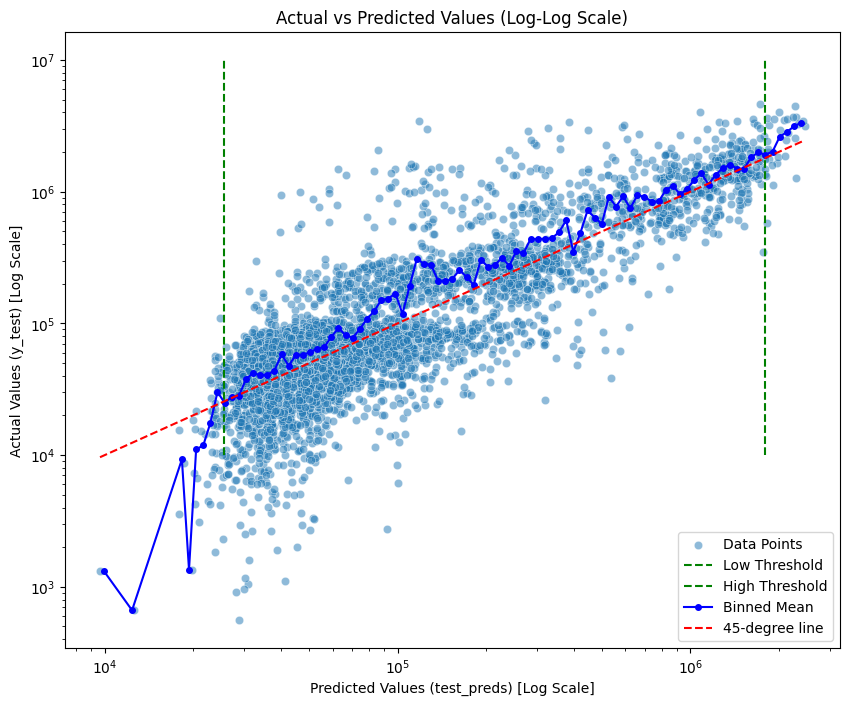

In [33]:

def calculate_binned_average(x, y, num_bins=50):
    """
    x を num_bins 個のビンに分け、それぞれのビン内の y の平均を計算します。

    Parameters:
    - x: 予測値の配列
    - y: 実測値の配列
    - num_bins: ビンの数

    Returns:
    - bins: ビンの境界
    - bin_centers: 各ビンの中心値
    - y_means: 各ビン内の y の平均値
    """
    # 対数スケールのビンを作成
    log_min = np.log10(x.min())
    log_max = np.log10(x.max())
    bins = np.logspace(log_min, log_max, num=num_bins)

    # ビンのインデックスを取得
    bin_indices = np.digitize(x, bins)

    # 各ビン内の y の平均を計算
    y_means = []
    bin_centers = []
    for i in range(1, len(bins)):
        mask = bin_indices == i
        if np.any(mask):
            y_mean = y[mask].mean()
            y_means.append(y_mean)
            bin_center = (bins[i-1] + bins[i]) / 2
            bin_centers.append(bin_center)

    return bins, np.array(bin_centers), np.array(y_means)


x = train_df["preds"]
y = train_df_GHG14
# ビンに分けて平均を計算
num_bins = 100
bins, bin_centers, y_means = calculate_binned_average(x, y, num_bins=num_bins)

# ジオメトリック平均の計算（ビンごとの y のジオメトリック平均）
geometric_mean_y_per_bin = np.exp(np.mean(np.log(y_means)))
print(f"各ビンの y のジオメトリック平均: {geometric_mean_y_per_bin}")

# プロットの作成
plt.figure(figsize=(10, 8))
sns.scatterplot(x=x, y=y, alpha=0.5, label='Data Points')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Actual Values (y_test) [Log Scale]')
plt.xlabel('Predicted Values (test_preds) [Log Scale]')
plt.title('Actual vs Predicted Values (Log-Log Scale)')


# 基準点の垂直線のプロット
plt.plot([np.expm1(10.15), np.expm1(10.15)], [10**4, 10**7], 'g--', label='Low Threshold')
plt.plot([np.expm1(14.4), np.expm1(14.4)], [10**4, 10**7], 'g--', label='High Threshold')

# ビンごとの平均値の線を追加
plt.plot(bin_centers, y_means, color='b', linestyle='-', marker='o', markersize=4, label='Binned Mean')
# 45度線のプロット
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--', label='45-degree line')

# 凡例の追加
plt.legend()

# プロットの表示
plt.show()

In [34]:
def after_act(preds):
    r = preds.copy()
    # for i in range(len(r)):
    #     if r[i] < np.expm1(10.15):
    #         r[i] = np.expm1(np.log1p(r[i])*100/102)
    return r

after_test_preds = after_act(test_df["GHG_Direct_Emissions_14_in_metric_tons.1"])
after_train_preds = after_act(train_df["preds"])

各ビンの y のジオメトリック平均: 223820.10331013403


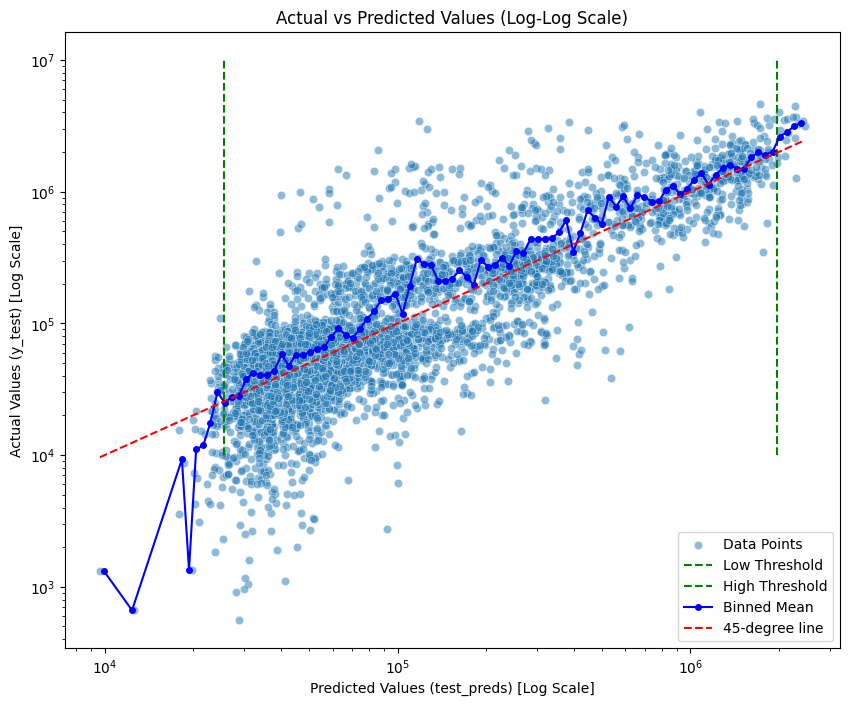

In [35]:
x = after_train_preds
y = train_df_GHG14

# ビンに分けて平均を計算
num_bins = 100
bins, bin_centers, y_means = calculate_binned_average(x, y, num_bins=num_bins)

# ジオメトリック平均の計算（ビンごとの y のジオメトリック平均）
geometric_mean_y_per_bin = np.exp(np.mean(np.log(y_means)))
print(f"各ビンの y のジオメトリック平均: {geometric_mean_y_per_bin}")

# プロットの作成
plt.figure(figsize=(10, 8))
sns.scatterplot(x=x, y=y, alpha=0.5, label='Data Points')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Actual Values (y_test) [Log Scale]')
plt.xlabel('Predicted Values (test_preds) [Log Scale]')
plt.title('Actual vs Predicted Values (Log-Log Scale)')

# 45度線のプロット
# plt.plot([train_target.min(), train_target.max()], [train_target.min(), train_target.max()], 'r--', label='45-degree line')

# 基準点の垂直線のプロット
plt.plot([np.expm1(10.15), np.expm1(10.15)], [10**4, 10**7], 'g--', label='Low Threshold')
plt.plot([np.expm1(14.5), np.expm1(14.5)], [10**4, 10**7], 'g--', label='High Threshold')

# ビンごとの平均値の線を追加
plt.plot(bin_centers, y_means, color='b', linestyle='-', marker='o', markersize=4, label='Binned Mean')
# 45度線のプロット
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--', label='45-degree line')

# 凡例の追加
plt.legend()

# プロットの表示
plt.show()

In [36]:
sum(test_df["GHG_Direct_Emissions_14_in_metric_tons.1"] > np.expm1(14.5)), sum(test_df["GHG_Direct_Emissions_14_in_metric_tons.1"] < np.expm1(10.15))

(6, 37)

In [37]:
submit [ 1 ]  =  after_test_preds
submit.to_csv('SMBC_59.csv', index = False)
submit

,0,1
0,4655,4.296952e+04
1,4656,2.997852e+05
2,4657,3.952780e+04
3,4658,2.743371e+04
4,4659,4.900245e+04
...,...,...
2503,7158,5.287770e+05
2504,7159,1.098642e+05
2505,7160,1.388429e+05
2506,7161,2.561824e+05


In [38]:
np.expm1(14)

1202603.2841647768

In [39]:
pd.set_option('display.float_format', '{:,.0f}'.format)
threshold_input = 14
threshold = np.expm1(threshold_input)/1.05  # ≈ 1.718

# フィルタリング条件を定義
condition = (submit.iloc[:, 1] > threshold) & (submit.iloc[:, 0] > 1)

# 条件に合致する行を抽出
filtered_submit = submit[condition]
filtered_submit

,0,1
110,4765,"1,336,858"
114,4769,"1,226,313"
148,4803,"1,731,882"
178,4833,"1,472,473"
187,4842,"1,599,891"
...,...,...
2417,7072,"1,223,245"
2423,7078,"1,205,071"
2466,7121,"1,603,248"
2490,7145,"1,371,683"


In [40]:

# # show_plot(np.exp(oof_predictions), np.exp(target))
# show_plot(oof_predictions, target, "oof_predictions, target")
# show_plot(np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]), np.log(train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]),
#           "train_df[GHG_Direct_Emissions_13_in_metric_tons], np.log(train_df[GHG_Direct_Emissions_14_in_metric_tons.1])")
# show_plot(np.log(test_df["GHG_Direct_Emissions_13_in_metric_tons"]), np.log(after_test_preds),
#           "test_df[GHG_Direct_Emissions_13_in_metric_tons], test_preds")
# show_plot(np.log(train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]), np.log(after_test_preds),
#           "train_df[GHG_Direct_Emissions_14_in_metric_tons], test_preds")
# show_plot(train_df.iloc[:, -1], after_train_preds, "train_df.iloc[:, -1], train_preds")

In [41]:
# show_plot(train_df["GHG_Direct_Emissions_14_in_metric_tons.1"], test_preds, "test_df[GHG_Direct_Emissions_13_in_metric_tons], test_preds")

In [42]:
import time
print(time.ctime())

Sun Dec  1 04:54:50 2024


In [43]:
train_df

,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff,preds
0,NaN,NaN,NaN,221,"98,034","49,591","58,399","55,459",39,-98,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"54,987",-2,"53,130"
1,NaN,NaN,NaN,240,"46,520","39,262","49,223","28,223",41,-85,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"38,313",1,"36,229"
2,NaN,NaN,NaN,80,"2,972,544","908,114","337,540","329,206",33,-82,NaN,NaN,NaN,NaN,NaN,NaN,8,1,"586,226",1,"663,336"
3,NaN,NaN,NaN,240,"11,979","37,279","53,168","60,125",39,-79,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"43,117",-1,"40,852"
4,"176,917","85,503","103,788",95,"3,251,417","432,917","298,033","601,348",42,-83,"97,948","-91,414","18,284",1,-1,0,8,0,"495,272",-1,"455,589"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4650,NaN,NaN,NaN,240,"2,046,407","275,337","4,630,881","99,464",37,-87,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"1,009,471",0,"1,054,266"
4651,NaN,NaN,NaN,21,"70,347","81,111","54,428","29,108",37,-82,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"55,967",-0,"55,413"
4652,NaN,NaN,NaN,3,"208,375","57,067","48,580","26,892",43,-110,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"50,239",-0,"48,739"
4653,NaN,NaN,NaN,244,"563,756","598,881","1,665,103","543,206",35,-97,NaN,NaN,NaN,NaN,NaN,NaN,5,1,"1,089,507",-0,"1,089,432"


In [44]:
def culc(x, y):
    return  np.sqrt(mean_squared_log_error(x, y))

culc(train_df_GHG14, train_df["preds"])

0.7090609096883101

In [45]:
train_df["GHG_Direct_Emissions_14_in_metric_tons.1"] = after_train_preds
train_df.drop(["preds"], axis=1, inplace=True)
train_df.drop(["diff"], axis=1, inplace=True)



In [46]:
test_df["test_preds"] = after_test_preds
test_df.drop(["diff"], axis=1, inplace=True)
test_df.drop(["GHG_Direct_Emissions_14_in_metric_tons.1"], axis=1, inplace=True)
test_df

,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,test_preds
0,NaN,NaN,NaN,4,"88,951","65,803","28,993","32,965",38,-98,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"44,594","42,970"
1,NaN,NaN,NaN,221,NaN,NaN,"311,926","268,668",32,-109,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"296,645","299,785"
2,"32,075","26,446","23,385",130,"84,908","6,213","34,733","39,045",41,-79,"3,800","-5,629","-3,061",0,-0,-0,8,0,"41,032","39,528"
3,"42,504","43,906","42,958",82,"49,005",52,"14,262","20,205",45,-93,"5,174","1,402",-948,0,0,-0,8,0,"30,125","27,434"
4,"39,898","40,203","39,437",181,"84,960","15,351","40,007","63,935",33,-117,"-5,413",306,-766,-0,0,-0,8,0,"47,570","49,002"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"523,079","528,777"
2504,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"100,312","109,864"
2505,"23,592","25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"134,940","138,843"
2506,"140,816","93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"262,619","256,182"


In [49]:
train_df.to_csv("train_all_df_079.csv", index=False)
test_df.to_csv("test_all_df_079.csv", index=False)

In [50]:
def calc(x, y):
    return np.sqrt(mean_squared_log_error(x, y))

calc(train_df_GHG14, after_train_preds)

0.7090609096883101